Please checkout this page for more info: https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh#scrollTo=x0WeP5PREUuy

In [1]:
import os
import time
import datetime
from typing import Any

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download("punkt")

c:\Users\fisha\anaconda3\envs\torch_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fisha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv("PCParts_DataSet.csv")
df = pd.DataFrame(df)
print(df)

       timestamp   company_name  \
0     1604570838  pccomponentes   
1     1604570839  pccomponentes   
2     1604570846  pccomponentes   
3     1604570849  pccomponentes   
4     1604570850  pccomponentes   
...          ...            ...   
7668  1604706375          pcbox   
7669  1604706379          pcbox   
7670  1604706382          pcbox   
7671  1604706386          pcbox   
7672  1604706389          pcbox   

                                                   name   brand_name  \
0              Gigabyte SSD M.2 512GB 2280 PCIe x2 NVMe     Gigabyte   
1     BitFenix Enso Cristal Templado USB 3.0 RGB Blanca     BitFenix   
2     PNY XLR8 CS3030 250GB M.2 3D TLC NVMe PCI-Express          PNY   
3     PNY XLR8 CS3030 500GB M.2 3D TLC NVMe PCI-Express          PNY   
4       PNY XLR8 CS3030 1TB M.2 3D TLC NVMe PCI-Express          PNY   
...                                                 ...          ...   
7668  FUENTE ALIMENTACION 650W NOX URANO VX 650 VENT...          NOX   
766

In [3]:
df.dropna()
parts_names = df.name.copy()
parts_names

0                Gigabyte SSD M.2 512GB 2280 PCIe x2 NVMe
1       BitFenix Enso Cristal Templado USB 3.0 RGB Blanca
2       PNY XLR8 CS3030 250GB M.2 3D TLC NVMe PCI-Express
3       PNY XLR8 CS3030 500GB M.2 3D TLC NVMe PCI-Express
4         PNY XLR8 CS3030 1TB M.2 3D TLC NVMe PCI-Express
                              ...                        
7668    FUENTE ALIMENTACION 650W NOX URANO VX 650 VENT...
7669    FUENTE ALIMENTACION 550W MARS GAMING MPB550 VE...
7670    FUENTE ALIMENTACION 550W APPROX APP550PS VENT....
7671    FUENTE ALIMENTACION 750W MARS GAMING MPB750 80...
7672    FUENTE ALIMENTACION 500W APPROX APP500PS VENT....
Name: name, Length: 7673, dtype: object

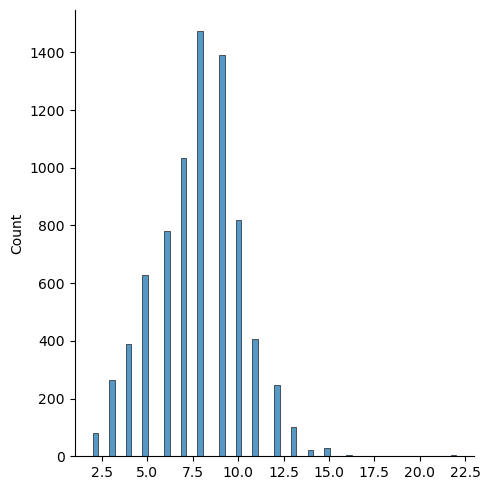

In [4]:
doc_lengths = []
for name in parts_names:
    # get token count distribution
    tokens = nltk.word_tokenize(name)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
sns.displot(doc_lengths)

In [5]:
# the max token length
len(doc_lengths[doc_lengths > 15]) / len(doc_lengths)

0.0011729440896650592

In [6]:
np.average(doc_lengths)

7.784178287501629

# GPT2 tokenizer

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", bos_token="<|startoftext|>", eos_token="<|endoftext|>", pad_token="<|pad|>")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [9]:
class GPT2Dataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768) -> None:
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        for txt in txt_list:
            encoding_dict = tokenizer("<|startoftext|>" + txt + "<|endoftext|>", truncation=True, max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encoding_dict["input_ids"]))
            self.attn_masks.append(torch.tensor(encoding_dict["attention_mask"]))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index) -> Any:
        return self.input_ids[index], self.attn_masks[index] 

In [10]:
batch_size = 2

In [11]:
dataset = GPT2Dataset(parts_names, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,905 training samples
  768 validation samples


In [12]:
# Create the DataLoaders for training and validation datasets.
# Training samples should be in random order.
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# Validation samples can be in any order, therefore, it'll be read sequentially.
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


# Fine-tune the GPT2 model


In [13]:
torch.cuda.is_available()

True

In [14]:
print(torch.__version__)

2.0.1


In [15]:
configuration = GPT2Config.from_pretrained("gpt2", output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model.resize_token_embeddings(len(tokenizer))

# Run this on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed to make it reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)    

In [16]:
# Parameters that works well (randomly selected)
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# This produces sample output every 100 steps
sample_every = 100

In [17]:
optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

c:\Users\fisha\anaconda3\envs\torch_cuda\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [19]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()
        outputs = model(b_input_ids, labels=b_labels,
                        attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(
                step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1, 30000),
                do_sample=True,
                top_k=50,
                max_length=200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(
                    sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids,
                            # token_type_ids=None,
                            attention_mask=b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(
    format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100  of  3,453. Loss: 0.06928711384534836.   Elapsed: 0:00:15.
0:  bipartisanGiantabyte Gaming DDR4 2400mhz 3200MHz OC DDR4 32GB 2x8GB GDDR5 32GB DDR4 3GB 2x4GB CL10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200  of  3,453. Loss: 0.043660469353199005.   Elapsed: 0:00:30.
0:  increasingGigabyte Aorus Pro SSD 2TB 6Ghz


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300  of  3,453. Loss: 0.04563777521252632.   Elapsed: 0:00:45.
0: dayAerocool ALACICA 4TB CL10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   400  of  3,453. Loss: 0.04787975177168846.   Elapsed: 0:00:59.
0:  HangKingston HyperX Fury


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   500  of  3,453. Loss: 0.040012817829847336.   Elapsed: 0:01:14.
0:  foodsTeam Group Delta RGB RGB USB 3.0 Negro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   600  of  3,453. Loss: 0.04362380504608154.   Elapsed: 0:01:29.
0:  trailTeam Group Delta White RGB DDR4 3000 PC4-24000 16GB 2x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   700  of  3,453. Loss: 0.07896921038627625.   Elapsed: 0:01:43.
0: intendCorsair Force Series 250GB SSD NVMe PCIe 3.1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   800  of  3,453. Loss: 0.05281418561935425.   Elapsed: 0:01:58.
0:  surroundCorsair Dominator Platinum RGB DDR3 3000 PC3-24000 32GB 2x16GB CL15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   900  of  3,453. Loss: 0.03514745831489563.   Elapsed: 0:02:13.
0:  reflexAsus ROG VENTUS ROG-STON RGB


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000  of  3,453. Loss: 0.035556361079216.   Elapsed: 0:02:27.
0:  displayG.Skill Ripjaws V DDR4 2666 PC4-21300 8GB 2x4GB CL14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,100  of  3,453. Loss: 0.025331638753414154.   Elapsed: 0:02:44.
0:  pastorAsus PRIME H470M-PLUS


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,200  of  3,453. Loss: 0.03871392831206322.   Elapsed: 0:02:58.
0:  illicitMars Gaming MC2 1200W 80 Plus Gold Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,300  of  3,453. Loss: 0.037739597260951996.   Elapsed: 0:03:13.
0:  LiberationNZXT H510 Cristal Templado USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,400  of  3,453. Loss: 0.04678976908326149.   Elapsed: 0:03:27.
0:  NamCorsair Vengeance LPX DDR4 2400 PC4-19200 8GB 2x4GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,500  of  3,453. Loss: 0.023453576490283012.   Elapsed: 0:03:42.
0: IONGigabyte Aorus Pro M550M 80 Plus Bronze


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,600  of  3,453. Loss: 0.029790500178933144.   Elapsed: 0:03:56.
0:  glimpseWD NAS Externo 500GB M.2 PCIe 3.0 con Fuente de Alimentación 500M


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,700  of  3,453. Loss: 0.02614440582692623.   Elapsed: 0:04:11.
0:  LaureCorsair Dominator Platinum RGB DDR4 3000MHz PC4-2400 16GB 2x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,800  of  3,453. Loss: 0.031616684049367905.   Elapsed: 0:04:25.
0: ismCorsair Vengeance LPX DDR4 2400 PC4-32000 16GB 2x8GB CL14


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,900  of  3,453. Loss: 0.029614603146910667.   Elapsed: 0:04:40.
0: ounLian Li O11 Dynamic Cristal Templado USB 3.1 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000  of  3,453. Loss: 0.04451967403292656.   Elapsed: 0:04:54.
0:  electionThermaltake Core Spec-Delta RGB Snow Edition Cristal Templado USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,100  of  3,453. Loss: 0.03248177096247673.   Elapsed: 0:05:09.
0:  crazyCrucial CT8G 3200Mhz PC4-25600 32GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,200  of  3,453. Loss: 0.042880311608314514.   Elapsed: 0:05:23.
0:  benchCorsair iCUE 600W Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,300  of  3,453. Loss: 0.03897301107645035.   Elapsed: 0:05:38.
0:  incorporatedAerocool CS-350G 250W


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,400  of  3,453. Loss: 0.01909255050122738.   Elapsed: 0:05:52.
0: PeterTeam Group T-Force Night Hawk White RGB DDR4 3000 PC4-24000 16GB 2x8GB CL15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,500  of  3,453. Loss: 0.04034118726849556.   Elapsed: 0:06:07.
0: uringSeagate Backup Plus Hub Ultra 3TB USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,600  of  3,453. Loss: 0.030377093702554703.   Elapsed: 0:06:22.
0:  reproductiveCrucial CT7G16S8/8ME DDR4 2400Mhz 4x8GB CL19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,700  of  3,453. Loss: 0.02924194000661373.   Elapsed: 0:06:36.
0:  zoneKingston HyperX Fury RGB DDR4 3200 PC4-25600 16GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,800  of  3,453. Loss: 0.039154816418886185.   Elapsed: 0:06:51.
0:  commitsCorsair X390 AirHawk X


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,900  of  3,453. Loss: 0.015266738831996918.   Elapsed: 0:07:05.
0:  ironyAsus GeForce GTX 1650 AERO ITX OCV1 6GB GDDR5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000  of  3,453. Loss: 0.024060586467385292.   Elapsed: 0:07:20.
0:  SahThermaltake Liten Snow Shadow RX 5600 XT AC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,100  of  3,453. Loss: 0.09728454798460007.   Elapsed: 0:07:34.
0:  Bryan0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,200  of  3,453. Loss: 0.15347003936767578.   Elapsed: 0:07:48.
0:  spiritsT Templ3.TixForceCTB-C


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,300  of  3,453. Loss: 0.16522741317749023.   Elapsed: 0:08:03.
0:  seesig5 Bronze4 3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,400  of  3,453. Loss: 0.061687882989645004.   Elapsed: 0:08:17.
0:  hungry.Seer AL Ryzen USB CL 3

  Average training loss: 0.07
  Training epoch took: 0:08:25

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:00:17

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100  of  3,453. Loss: 0.09127695113420486.   Elapsed: 0:00:14.
0:  PT0al Templado USB USB 3.0.0W Gold


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200  of  3,453. Loss: 0.07506737112998962.   Elapsed: 0:00:29.
0: üMS Fury Sabyte USB 3.1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300  of  3,453. Loss: 0.09203232824802399.   Elapsed: 0:00:43.
0: ruceTeam X DDR4-25 DDR4 PC4 CL1624 3625 8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   400  of  3,453. Loss: 0.06440609693527222.   Elapsed: 0:00:57.
0:  derivativesAsus Gaming H500 Gaming X-F RGB DDR4-19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   500  of  3,453. Loss: 0.10303507000207901.   Elapsed: 0:01:12.
0: Intel SSD III SSD 2GB 2200 XT Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   600  of  3,453. Loss: 0.07603323459625244.   Elapsed: 0:01:26.
0:  rememberingD.4-10G" 12 Plus Bronze


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   700  of  3,453. Loss: 0.03207036480307579.   Elapsed: 0:01:41.
0:  SourcesA-Tempest Shadow USB 3.1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   800  of  3,453. Loss: 0.03950868546962738.   Elapsed: 0:01:55.
0: emsCooler Master Master Cosmos USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   900  of  3,453. Loss: 0.02661905623972416.   Elapsed: 0:02:10.
0: tzG.Skill Aegis DDR4 2400 PC4-19200 PC4-19200 2x16GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000  of  3,453. Loss: 0.027142342180013657.   Elapsed: 0:02:24.
0: maticHiditec B1 Fuente de Alimentación 500W


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,100  of  3,453. Loss: 0.04094363749027252.   Elapsed: 0:02:39.
0:  syndAsrock A520M2M6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,200  of  3,453. Loss: 0.026545440778136253.   Elapsed: 0:02:54.
0:  gamZotac GeForce RTX 2070 Gaming OC Edition 8GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,300  of  3,453. Loss: 0.02104325033724308.   Elapsed: 0:03:08.
0:  injuryGoodRam DDR4 2400MHz 4GB CL15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,400  of  3,453. Loss: 0.022566404193639755.   Elapsed: 0:03:23.
0: azaWD My Passport Go SSD Externo 500GB 2.5" USB 3.0 Blanco


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,500  of  3,453. Loss: 0.033036209642887115.   Elapsed: 0:03:38.
0:  membraneCAX Cristal Templado USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,600  of  3,453. Loss: 0.01967478170990944.   Elapsed: 0:03:53.
0: ijingG.Skill Trident Z RGB DDR4 32GB 2x8GB 4x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,700  of  3,453. Loss: 0.026097262278199196.   Elapsed: 0:04:10.
0:  castMSI MPG 100R Cristal Templado USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,800  of  3,453. Loss: 0.02880784496665001.   Elapsed: 0:04:33.
0:  purchThermaltake S100 Cristal Templado USB 3.0 ARGB


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,900  of  3,453. Loss: 0.03451109677553177.   Elapsed: 0:04:54.
0:  shouldersThermaltake Core i5-F Cristal Templado USB 3.1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000  of  3,453. Loss: 0.04584546014666557.   Elapsed: 0:05:19.
0:  builtPhanteks Eclipse P400S Cristal Templado USB 3.0 Blanca


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,100  of  3,453. Loss: 0.0360737182199955.   Elapsed: 0:05:47.
0:  openlyLian-Li PC-O11D8C-11DVI-PL42400


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,200  of  3,453. Loss: 0.025647355243563652.   Elapsed: 0:06:15.
0:  haltedTeam Group T-Force Vulcan Z DDR4 4000 PC4-32000 32GB 2x8GB CL16 Rojo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,300  of  3,453. Loss: 0.025380471721291542.   Elapsed: 0:06:39.
0:  NikSamsung 970 EVO Plus 2TB SSD SATA3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,400  of  3,453. Loss: 0.01675375923514366.   Elapsed: 0:07:03.
0:  tinUNYKAch Umbrella USB 3.0 con Ventana Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,500  of  3,453. Loss: 0.026751982048153877.   Elapsed: 0:07:18.
0:  clinicalBitFenix Nova Semitorre ATX con Ventana


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,600  of  3,453. Loss: 0.023726504296064377.   Elapsed: 0:07:33.
0: lectionsTeam Group Cardea Zero Z490 2.5" 1TB SSD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,700  of  3,453. Loss: 0.017272498458623886.   Elapsed: 0:07:49.
0: elsAMD Ryzen 5 3600XT 3.70 GHz


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,800  of  3,453. Loss: 0.029843319207429886.   Elapsed: 0:08:05.
0: labAdata SSD Exos X16 SED 3D NAND TLC


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,900  of  3,453. Loss: 0.01956847682595253.   Elapsed: 0:08:20.
0:  tripleAdata Ultimate SU630 2TB SSD M.2 PCI Express 3.0 NVMe


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000  of  3,453. Loss: 0.019489901140332222.   Elapsed: 0:08:36.
0: 220PNY Elite SSD 480GB USB 3.1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,100  of  3,453. Loss: 0.022962749004364014.   Elapsed: 0:08:51.
0:  SeeMEMORIA 4 GB DDR3 1600 KINGSTON CL9 VALUE


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,200  of  3,453. Loss: 0.0196427833288908.   Elapsed: 0:09:17.
0: @@Corsair Obsidian 110X USB 3.0 con Ventana Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,300  of  3,453. Loss: 0.024050524458289146.   Elapsed: 0:15:48.
0:  hostEVGA Supernova 1000 GT 550W 80 Plus Gold Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,400  of  3,453. Loss: 0.029415123164653778.   Elapsed: 0:18:54.
0: roleG.Skill FlareX DDR4 2400 PC4-19200 8GB CL17

  Average training loss: 0.04
  Training epoch took: 0:19:08

Running Validation...
  Validation Loss: 0.03
  Validation took: 0:00:54

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100  of  3,453. Loss: 0.021336952224373817.   Elapsed: 0:01:52.
0: iacNZXT H510 Cristal Templado USB 3.1 Blanco Mate


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200  of  3,453. Loss: 0.016312137246131897.   Elapsed: 0:04:55.
0:  LDKingston HyperX Fury DDR4 3000 PC4-24000 16GB 2x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300  of  3,453. Loss: 0.019517775624990463.   Elapsed: 0:08:49.
0:  ListenMSI GeForce GTX 1650 AERO ITX OC 6GB GDDR5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   400  of  3,453. Loss: 0.024656005203723907.   Elapsed: 0:12:42.
0:  dySapphire Pulse Radeon RX 5600 XT 6GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   500  of  3,453. Loss: 0.024736085906624794.   Elapsed: 0:12:57.
0:  DomesticAsus TUF Gaming GT710 Plus


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   600  of  3,453. Loss: 0.015928758308291435.   Elapsed: 0:13:13.
0:  beneficiariesNfortec Caelum White RGB Cristal Templado USB 3.0 RGB Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   700  of  3,453. Loss: 0.018250994384288788.   Elapsed: 0:13:30.
0:  TitleTeam Group T-Force Dark Z Alpha AMD DDR4 3200MHz PC4-25600 16GB 2x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   800  of  3,453. Loss: 0.01701226457953453.   Elapsed: 0:17:19.
0:  μThermaltake View 31 TG Cristal Templado USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   900  of  3,453. Loss: 0.01962856389582157.   Elapsed: 0:17:47.
0:  sellingMSI X299-A PRO


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000  of  3,453. Loss: 0.018948011100292206.   Elapsed: 0:18:17.
0:  migrantThermaltake Level 20 MT ARGB Cristal Templado USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,100  of  3,453. Loss: 0.02051471918821335.   Elapsed: 0:18:48.
0: ivelyWD My Cloud Home Duo 16TB 3.5" USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,200  of  3,453. Loss: 0.017572473734617233.   Elapsed: 0:21:48.
0:  orderMSI A320M PRO-VD Plus


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,300  of  3,453. Loss: 0.014569689519703388.   Elapsed: 0:28:21.
0:  VPNPNY XLR8 RGB DDR4 3200 PC4-25600 16GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,400  of  3,453. Loss: 0.020077448338270187.   Elapsed: 0:34:14.
0:  explanationAdata XGP SX6000 Lite 512GB SSD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,500  of  3,453. Loss: 0.016918227076530457.   Elapsed: 0:34:45.
0:  BachCorsair Vengeance RGB Pro DDR4 3600 16GB 2x8GB CL18 Blanco


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,600  of  3,453. Loss: 0.023791775107383728.   Elapsed: 0:35:17.
0:  folderMars Gaming MCK 750W 80 Plus Bronze Semi Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,700  of  3,453. Loss: 0.021573374047875404.   Elapsed: 0:36:13.
0:  buildingKolink Enclave 700W 80 Plus Gold Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,800  of  3,453. Loss: 0.019990727305412292.   Elapsed: 0:37:08.
0:  BabylonGoodRam DDR4 2666MHz 8GB CL19


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,900  of  3,453. Loss: 0.022626882418990135.   Elapsed: 0:40:58.
0: perialTeam Group T-Force Dark Z DDR4 3200MHz PC4-25600 32GB 2x16GB CL16 Gris


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000  of  3,453. Loss: 0.021201694384217262.   Elapsed: 0:45:34.
0:  rentsAsus PRIME H410M-A


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,100  of  3,453. Loss: 0.02312595583498478.   Elapsed: 0:45:59.
0:  RegAdata Ultimate SU630 480GB SSD M.2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,200  of  3,453. Loss: 0.028134474530816078.   Elapsed: 0:46:24.
0: olasDeepcool Matrexx 50 ADD-RGB 4F Cristal Templado USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,300  of  3,453. Loss: 0.023529306054115295.   Elapsed: 0:52:23.
0:  responsesCorsair iCUE 220T Cristal Templado USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,400  of  3,453. Loss: 0.014397846534848213.   Elapsed: 0:52:47.
0:  attendanceToshiba Canvio Advance 4TB 2.5" USB 3.2 Negro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,500  of  3,453. Loss: 0.016789624467492104.   Elapsed: 0:53:09.
0:  rigidKingston KJ08G DDR4 2400MHz PC4-19200 16GB 2x8GB CL17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,600  of  3,453. Loss: 0.0313570462167263.   Elapsed: 0:53:32.
0: groCrucial Ballistix SO-DIMM DDR4 2400MHz PC4-19200 4GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,700  of  3,453. Loss: 0.03455684706568718.   Elapsed: 0:53:55.
0:  GreWD Green 3D SSD 1TB SATA3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,800  of  3,453. Loss: 0.01917140930891037.   Elapsed: 0:54:40.
0: uraAMD R5 230 2GB GDDR5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,900  of  3,453. Loss: 0.02733413130044937.   Elapsed: 0:55:08.
0:  2020Asus ROG Strix Gaming GeForce GTX 1660 SUPER OC Edition 6GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000  of  3,453. Loss: 0.0269085131585598.   Elapsed: 0:55:37.
0:  chargingZotac GAMING GeForce RTX 3080 Trinity 10GB GDDR6X


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,100  of  3,453. Loss: 0.021780950948596.   Elapsed: 0:55:51.
0:  SarWestern Digital Black PCIe Gen3 SSD M.2 512GB SATA3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,200  of  3,453. Loss: 0.03461132198572159.   Elapsed: 0:56:06.
0:  JasSeagate Exos X16 SAS SSD 1TB USB-C 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,300  of  3,453. Loss: 0.01992732286453247.   Elapsed: 0:56:20.
0:  permitMSI MAG B460M BAZOOKA 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,400  of  3,453. Loss: 0.02759453095495701.   Elapsed: 0:56:34.
0:  AdministratorCrucial BX500 SSD 960GB 3D NAND SATA3

  Average training loss: 0.02
  Training epoch took: 0:56:42

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:00:17

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100  of  3,453. Loss: 0.015027905814349651.   Elapsed: 0:00:14.
0:  EVENTSCorsair Vengeance RGB Pro DDR4 3200 PC4-25600 16GB 2x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200  of  3,453. Loss: 0.02371560037136078.   Elapsed: 0:00:29.
0:  MentalAMD Ryzen 7 3800X 3.8GHz BOX


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300  of  3,453. Loss: 0.020731426775455475.   Elapsed: 0:00:43.
0: idsWD Red 2TB 3.5" SATA3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   400  of  3,453. Loss: 0.027276011183857918.   Elapsed: 0:00:57.
0: ceansUNYKAch Caviar 1K USB 3.0 Negra + Fuente de Alimentación 500W


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   500  of  3,453. Loss: 0.01142806001007557.   Elapsed: 0:01:11.
0:  geneticallyGoodRam SODIMM DDR3 1333MHz 8GB CL9 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   600  of  3,453. Loss: 0.01510937325656414.   Elapsed: 0:01:25.
0:  adviceL-Link ATX Cristal Templado USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   700  of  3,453. Loss: 0.01860530860722065.   Elapsed: 0:01:39.
0:  incompleteCorsair Vengeance RGB Pro DDR4 2400 PC4-19200 8GB 2x4GB CL15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   800  of  3,453. Loss: 0.018605664372444153.   Elapsed: 0:01:54.
0: commentSapphire Nitro+ Radeon RX 5500 XT 8GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   900  of  3,453. Loss: 0.01643216609954834.   Elapsed: 0:02:08.
0:  pilotThermaltake View 71 USB 3.0 con Ventana Blanco


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000  of  3,453. Loss: 0.017031768336892128.   Elapsed: 0:02:22.
0: gersNfortec Lynx Cristal Templado USB 3.0 RGB Negro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,100  of  3,453. Loss: 0.01840812712907791.   Elapsed: 0:02:36.
0:  mutationBitFenix Whisper Fuente de Alimentación 750W 80+ Gold


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,200  of  3,453. Loss: 0.01998784765601158.   Elapsed: 0:02:51.
0:  DriverAerocool Sentinel RGB USB 3.0 Cristal Templado


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,300  of  3,453. Loss: 0.01978457160294056.   Elapsed: 0:03:05.
0: itiCAJA SEMITORRE HIDITEC Z20 NEGRA USB3.0 ARGB


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,400  of  3,453. Loss: 0.014338851906359196.   Elapsed: 0:03:19.
0: fffWD Elements 2017 4TB 2.5" USB 3.0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,500  of  3,453. Loss: 0.015480504371225834.   Elapsed: 0:03:33.
0: riminationBe Quiet! SFX L Power 600W 80 Plus Gold Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,600  of  3,453. Loss: 0.02267199382185936.   Elapsed: 0:03:48.
0: aqueThermaltake Toughpower PF1 ARGB 850W 80 Plus Platinum Full Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,700  of  3,453. Loss: 0.017732229083776474.   Elapsed: 0:04:02.
0: leeMemoria Ram Kingston HyperX Impact SODIMM DDR4 2933MHZ 8GB CL17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,800  of  3,453. Loss: 0.01882125996053219.   Elapsed: 0:04:16.
0:  AlzheimerIntel i5-10600K 4.10 GHz


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,900  of  3,453. Loss: 0.01778881996870041.   Elapsed: 0:04:30.
0:  checkingG.Skill Trident Z RGB DDR4 3600 PC4-28800 16GB 2x8GB CL17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000  of  3,453. Loss: 0.015635458752512932.   Elapsed: 0:04:45.
0: nesiumAsus PRIME B550-PLUS


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,100  of  3,453. Loss: 0.01486977469176054.   Elapsed: 0:04:59.
0:  1957Tacens Imperator USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,200  of  3,453. Loss: 0.01765514723956585.   Elapsed: 0:05:13.
0: manshipCorsair Vengeance RGB Pro DDR4 3600 PC4-28800 8GB CL18


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,300  of  3,453. Loss: 0.027639802545309067.   Elapsed: 0:05:27.
0:  understandL-Link Fuente de Alimentación 650W PFC + Fórmula Gold 650W


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,400  of  3,453. Loss: 0.014770622365176678.   Elapsed: 0:05:41.
0:  passionSilverStone Milo ML03B Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,500  of  3,453. Loss: 0.019094349816441536.   Elapsed: 0:05:55.
0:  curvedFractal Design Define S2 TG USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,600  of  3,453. Loss: 0.01743226870894432.   Elapsed: 0:06:09.
0:  AnKingston HyperX Fury Black 8GB DDR4 3000Mhz PC-24000 (2x4GB) CL15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,700  of  3,453. Loss: 0.01696590520441532.   Elapsed: 0:06:24.
0: ottiG.Skill SO-DIMM DDR3 1600 PC3-12800 4GB CL11 Para Mac


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,800  of  3,453. Loss: 0.014787368476390839.   Elapsed: 0:06:38.
0:  intakeAdata SD700 SSD Externo 2.5" 2TB USB 3.2 Amarillo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,900  of  3,453. Loss: 0.017767729237675667.   Elapsed: 0:06:52.
0:  TsGigabyte Z490 AORUS ULTRA G2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000  of  3,453. Loss: 0.01692359521985054.   Elapsed: 0:07:06.
0:  MainSharkoon V1000 USB 3.0 Negra sin ODD


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,100  of  3,453. Loss: 0.04729890450835228.   Elapsed: 0:07:21.
0:  temWD Blue 3D Nand SSD SATA 250GB


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,200  of  3,453. Loss: 0.018045708537101746.   Elapsed: 0:07:35.
0:  ClickUNYKAch Armor White USB 3.0 con Ventana Negro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,300  of  3,453. Loss: 0.01280303206294775.   Elapsed: 0:07:49.
0:  XVTeam Group T-Force Night Hawk White RGB DDR4 3000 PC4-24000 32GB 2x16 CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,400  of  3,453. Loss: 0.01778988353908062.   Elapsed: 0:08:03.
0:  dormCooler Master MasterCase H500 RGB Cristal Templado USB 3.0

  Average training loss: 0.02
  Training epoch took: 0:08:11

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:00:17

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100  of  3,453. Loss: 0.028374621644616127.   Elapsed: 0:00:14.
0:  upstreamAsus PRIME H410M-C/CSM


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200  of  3,453. Loss: 0.01689562387764454.   Elapsed: 0:00:28.
0: الG.Skill Aegis DDR3 1600 PC3-12800 8GB CL11


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300  of  3,453. Loss: 0.014917030930519104.   Elapsed: 0:00:42.
0: ariaNfortec Krater Mini Cristal Templado USB 3.0 ARGB Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   400  of  3,453. Loss: 0.01983914151787758.   Elapsed: 0:00:56.
0: PGCorsair RM850X V2 850W 80 Plus Gold Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   500  of  3,453. Loss: 0.022357860580086708.   Elapsed: 0:01:11.
0: IllSilicon Power XPOWER Turbine 2666 DDR4 16GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   600  of  3,453. Loss: 0.01182338036596775.   Elapsed: 0:01:25.
0:  automatedMSI GeForce GTX 1050 Ti AERO ITX 4GB GDDR5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   700  of  3,453. Loss: 0.018636628985404968.   Elapsed: 0:01:39.
0:  hiringThermaltake V21 USB 3.0 Cristal Templado Blanco


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   800  of  3,453. Loss: 0.015022037550807.   Elapsed: 0:01:53.
0:  tweetingSeagate IronWolf NAS 10 TB SATA3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   900  of  3,453. Loss: 0.014890986494719982.   Elapsed: 0:02:07.
0: abitLian Li PC-O11 Dynamic Cristal Templado USB 3.1 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,000  of  3,453. Loss: 0.016170131042599678.   Elapsed: 0:02:21.
0:  iiCorsair Dominator Platinum RGB DDR4 3200 PC4-25600 32GB 2x16GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,100  of  3,453. Loss: 0.016160905361175537.   Elapsed: 0:02:35.
0: clipTARJETA CONTROLADORA ALTA VELOCIDAD PCIE GEN2 PARA SSD M2 NVME M2


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,200  of  3,453. Loss: 0.01614144630730152.   Elapsed: 0:02:50.
0:  FrancGigabyte GeForce RTX 2060 Super Gaming OC 8GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,300  of  3,453. Loss: 0.018141672015190125.   Elapsed: 0:03:04.
0:  listeningGigabyte B550 AORUS AORUS PRO


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,400  of  3,453. Loss: 0.017692048102617264.   Elapsed: 0:03:18.
0:  EUMEMORIA KIT 16 GB (2X8 GB) DDR4 3000 CORSAIR VENGEANCE PRO RGB CL15


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,500  of  3,453. Loss: 0.010561415925621986.   Elapsed: 0:03:32.
0:  incredibleAsus ROG Strix B360-H Gaming


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,600  of  3,453. Loss: 0.013215049169957638.   Elapsed: 0:03:46.
0:  TYTacens Imperator USB 3.0 Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,700  of  3,453. Loss: 0.014120761305093765.   Elapsed: 0:04:00.
0:  230Tacens Anima AC0300 + Fuente de Alimentación 500W


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,800  of  3,453. Loss: 0.016291419044137.   Elapsed: 0:04:15.
0:  TigersThermaltake Smart RGB 700W 80 Plus


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1,900  of  3,453. Loss: 0.01358958799391985.   Elapsed: 0:04:29.
0: CDBitfenix Nova Mesh TB Cristal Templado RGB Negra


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,000  of  3,453. Loss: 0.011322666890919209.   Elapsed: 0:04:43.
0:  unbelievableCorsair Vengeance LPX DDR4 3000 PC4-24000 16GB 2x8GB CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,100  of  3,453. Loss: 0.017672089859843254.   Elapsed: 0:04:57.
0: RobertPhanteks Eclipse P500A ARGB Cristal Templado USB 3.0 Blanca


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,200  of  3,453. Loss: 0.013147570192813873.   Elapsed: 0:05:11.
0:  ContactThermaltake Toughpower Grand RGB 1200W 80 Plus Gold Full Modular


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,300  of  3,453. Loss: 0.01596078835427761.   Elapsed: 0:05:25.
0:  fountainAsrock J4105M


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,400  of  3,453. Loss: 0.012623663991689682.   Elapsed: 0:05:40.
0:  clashKingston HyperX Fury Black 16GB DDR4 2666Mhz PC-21300 CL16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,500  of  3,453. Loss: 0.014632848091423512.   Elapsed: 0:05:54.
0:  commodKingston HyperX Fury Blue DDR3 1866MHz 16GB 2x8GB CL10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,600  of  3,453. Loss: 0.01304191816598177.   Elapsed: 0:06:08.
0:  algorithmAsus GeForce RTX 2060 O8G EVO Edition OC 6GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,700  of  3,453. Loss: 0.012850817292928696.   Elapsed: 0:06:22.
0:  accurateG.Skill Value DDR2 800 PC2-6400 2GB CL5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,800  of  3,453. Loss: 0.012400185689330101.   Elapsed: 0:06:36.
0: adoSamsung T7 Touch SSD 1TB USB 3.2 Plata


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2,900  of  3,453. Loss: 0.013792512938380241.   Elapsed: 0:06:50.
0:  regulateMSI Radeon RX 5700 XT Gaming X 8GB GDDR6


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,000  of  3,453. Loss: 0.013622600585222244.   Elapsed: 0:07:05.
0: ewayCorsair Crystal 680X RGB Cristal Templado USB 3.0 Blanca


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,100  of  3,453. Loss: 0.017475541681051254.   Elapsed: 0:07:19.
0: itteeMSI B450-A Pro Max


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,200  of  3,453. Loss: 0.013420657254755497.   Elapsed: 0:07:33.
0:  JackieGoodRam IRDM DDR4 2400MHz 8GB CL15 Negro


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,300  of  3,453. Loss: 0.012678173370659351.   Elapsed: 0:07:47.
0: HeWD Red SA500 NAS 2TB SSD SATA M.2 2280


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3,400  of  3,453. Loss: 0.015031342394649982.   Elapsed: 0:08:01.
0:  wiredAdata XPG Flame SO-DIMM DDR4 2666 PC4-21300 16GB 2x8GB CL18

  Average training loss: 0.02
  Training epoch took: 0:08:09

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:00:17

Training complete!
Total training took 1:42:35 (h:mm:ss)


In [21]:
# Display floats with two decimal places.
pd.options.display.precision = 2

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

OptionError: Pattern matched multiple keys

In [23]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

NameError: name 'df_stats' is not defined

In [24]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [22]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [25]:
# Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

# Generate text

In [30]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: EVGA W1 500W 80 Plus


1: Corsair Vengeance LPX DDR4 3200MHz PC4-25600 16GB CL16


2: MEMORIA 8 GB DDR4 2400 CRUCIAL CL17


